# Global imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Customized score functions
from qksvm.scores import get_scores, print_scores, print_cv_scores

# Custom visualization tools
from qksvm.visualization_tools import plot_dataset, plot_predictions, plot_decisions

seed = 1234

# Dataset

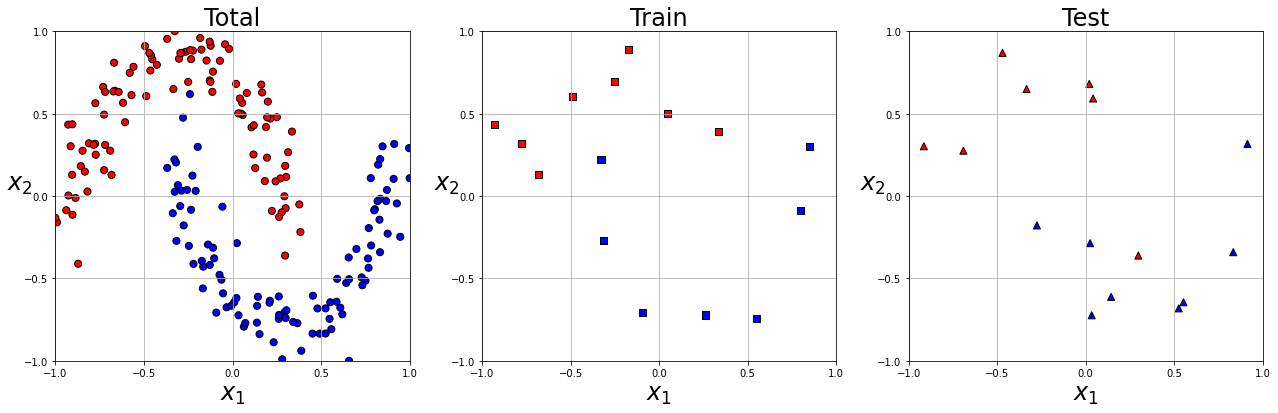

In [2]:
# Sklearn imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn import metrics
from sklearn.datasets import make_moons
np.random.seed(seed)

# Total number of the dataset points
n_samples = 200
X, y = make_moons(n_samples=n_samples, noise=0.1, random_state=seed)
y = 2*y-1 # rescale to [-1,1]

# Data rescaling
xmin = -1; xmax = 1
X = MinMaxScaler(feature_range=(xmin, xmax), copy=False).fit_transform(X)

train_size = 15 
test_size = 15 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=train_size, 
                                                    test_size=test_size, 
                                                    stratify=y,
                                                    random_state=seed)

# Visualize the dataset
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
axes = [xmin, xmax, xmin, xmax]

ax1.set_title("Total", fontsize=24)
plot_dataset(X, y, ax1, axes)

ax2.set_title("Train", fontsize=24)
plot_dataset(X_train, y_train, ax2, axes, marker='s', size=80)

ax3.set_title("Test", fontsize=24)
plot_dataset(X_test, y_test, ax3, axes, marker='^', size=100)

plt.rcParams['font.size'] = 15
plt.tight_layout()
plt.show()

# QKT SVM

## Setting up the quantum feature map 

In [3]:
from qksvm.QuantumFeatureMap import QuantumFeatureMap

## Specify Feature Map
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=2,
    num_layers=2,
    gates=['ry', 'cz', 'RX'], entanglement='linear',
    repeat=True,
    scale=True,
)
print(fm.draw(plot_barriers=False, fold=120))

     ┌──────────┐     ┌───────────────┐ ┌──────────┐     ┌───────────────┐ 
q_0: ┤ Ry(θ[1]) ├──■──┤ Rx(x[0]*θ[0]) ├─┤ Ry(θ[3]) ├──■──┤ Rx(x[0]*θ[0]) ├─
     ├──────────┤  │  ├───────────────┤ ├──────────┤  │  ├───────────────┤ 
q_1: ┤ Ry(θ[2]) ├──■──┤ Rx(x[1]*θ[0]) ├─┤ Ry(θ[4]) ├──■──┤ Rx(x[1]*θ[0]) ├─
     └──────────┘     └───────────────┘ └──────────┘     └───────────────┘ 


## Examine dependence of the kernel loss function on the data scaling prefactor

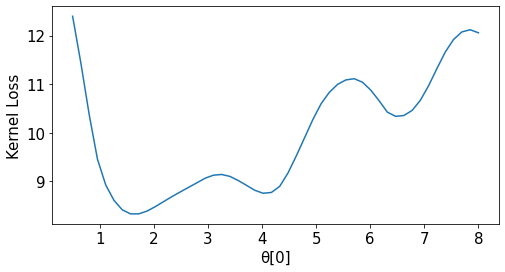

In [4]:
from qksvm.QKSVM import plot_kernel_loss

np.random.seed(seed)
params = np.random.uniform(0, 2*np.pi, len(fm.train_params))
plot_kernel_loss(fm, X_train, y_train, params=params, grid=[0.5, 8, 50], seed=seed)

## Quantum Kernel Training

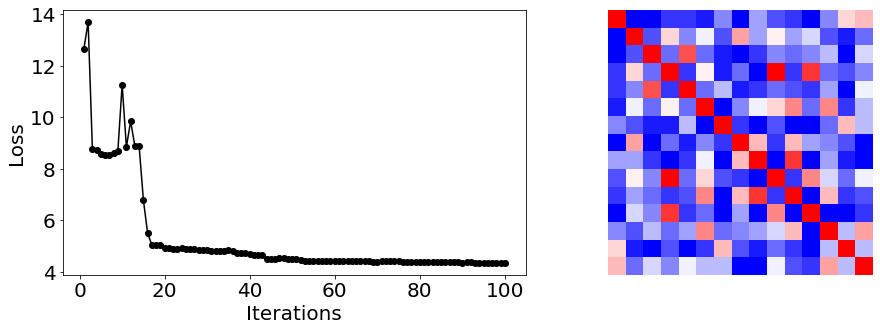

{   'optimal_parameters': {   ParameterVectorElement(θ[0]): 2.834249087816708,
                              ParameterVectorElement(θ[1]): -0.4398032255329425,
                              ParameterVectorElement(θ[2]): -1.4030801312132113,
                              ParameterVectorElement(θ[4]): 8.366517733924953,
                              ParameterVectorElement(θ[3]): 5.464587744679486},
    'optimal_point': array([ 2.83424909, -0.43980323, -1.40308013,  5.46458774,  8.36651773]),
    'optimal_value': 4.352766869297591,
    'optimizer_evals': 300,
    'optimizer_time': None,
    'quantum_kernel': <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x7f8d20932350>}

Train scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00

Test scores:
   Balanced accuracy:  0.93
                  F1:  0.94
             ROC_AUC:  1.00


In [5]:
from qksvm.QKSVM import QSVM_QKT

qsvc = QSVM_QKT(
    fm,
    X_train, y_train,
    scale0=2.0, maxiter=100,
    verbose=True, plot=True,
    seed=seed
)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

In [6]:
scores_ = get_scores(qsvc, X, y)
print_scores(scores_, title='Entire set:')


Entire set:
   Balanced accuracy:  0.98
                  F1:  0.98
             ROC_AUC:  1.00


## Predictions/Decision boundaries plot

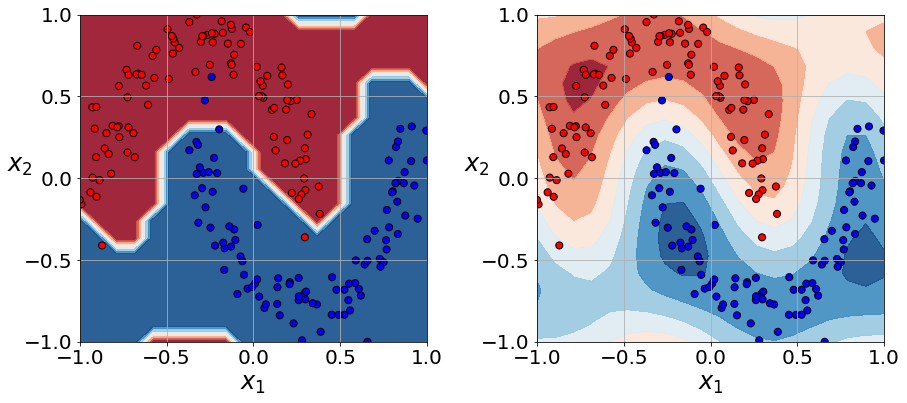

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

plot_predictions(qsvc, ax1, axes, N=20)
plot_dataset(X, y, ax1, axes)

plot_decisions(qsvc, ax2, axes, N=20)
plot_dataset(X, y, ax2, axes)

plt.tight_layout()
plt.show()

## Model cross-validation

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold

scoring = 0 # 0=acc, 1=f1, 2=roc
best_score = 0.0
scores_tr = []
scores_tt = []

# train_size = 10
# test_size = 10

n_splits = 5
# cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=100)
cv = StratifiedShuffleSplit(
    n_splits=n_splits, 
    train_size=train_size, test_size=test_size, 
    random_state=seed
)

i = 0
for train, test in cv.split(X, y):
    i += 1
    print(f"Train/Test CV Subset {i}/{n_splits}", end='\r')
    
    qsvc = QSVM_QKT(
        fm,
        X[train], y[train],
        scale0=2.0, maxiter=100,
        seed=seed,
        verbose=False,
    )
    scores_tr.append(get_scores(qsvc, X_train, y_train))
    scores_tt.append(get_scores(qsvc, X_test, y_test))
    if scores_tt[-1][scoring] > best_score:
        best_score = scores_tt[-1][scoring]
        best_qsvc = qsvc

print('\n\n==== Cross-Validation Scores ====')
print("\nBest train score: ", best_score)
print_cv_scores(scores_tr, title='Train set:')
print_cv_scores(scores_tt, title='Test set:')

Train/Test CV Subset 5/5

==== Cross-Validation Scores ====

Best train score:  0.9375

Train set:
   Balanced accuracy:  0.96 +- 0.03
                  F1:  0.96 +- 0.04
             ROC_AUC:  1.00 +- 0.01

Test set:
   Balanced accuracy:  0.92 +- 0.03
                  F1:  0.93 +- 0.03
             ROC_AUC:  0.97 +- 0.03


In [9]:
scores_ = get_scores(best_qsvc, X, y)
print_scores(scores_, title='Best model / Entire set:')


Best model / Entire set:
   Balanced accuracy:  0.96
                  F1:  0.96
             ROC_AUC:  1.00


## Best QSVM CV Predictions/Decision boundaries plot

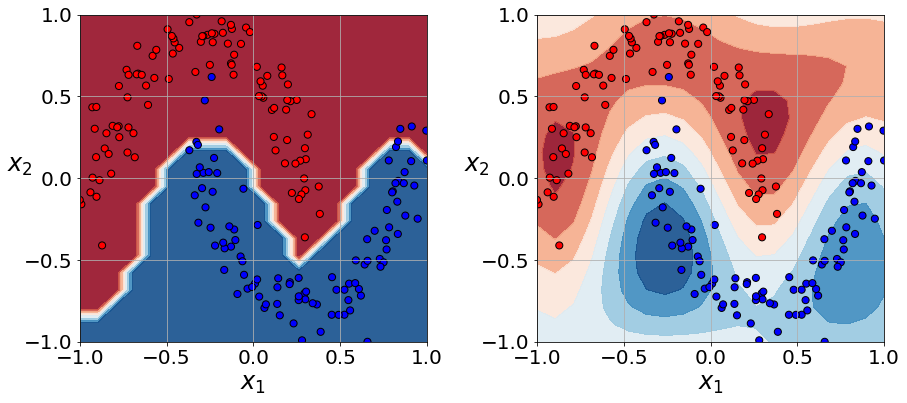

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

plot_predictions(best_qsvc, ax1, axes, N=20)
plot_dataset(X, y, ax1, axes)

plot_decisions(best_qsvc, ax2, axes, N=20)
plot_dataset(X, y, ax2, axes)

plt.tight_layout()
plt.show()